In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras import models, layers

# Background Research


In [2]:
train = tf.keras.utils.image_dataset_from_directory(
    'test/train/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 9028 files belonging to 15 classes.


In [3]:
validation = tf.keras.utils.image_dataset_from_directory(
    'test/validation/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


In [4]:
test = tf.keras.utils.image_dataset_from_directory(
    'test/test/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a critical step in understanding and preparing data for various purposes, including machine learning and data-driven decision-making. We can perform EDA to further our understanding of the data, and to make better decisions on how we can process it to make it easier for our model to understand.

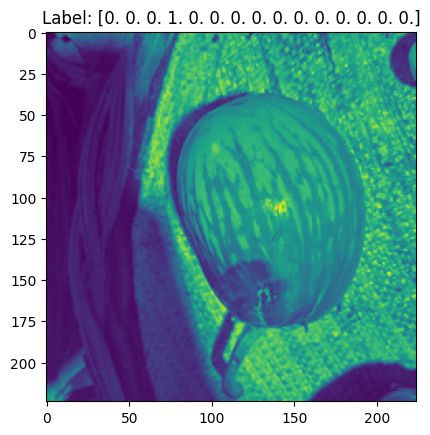

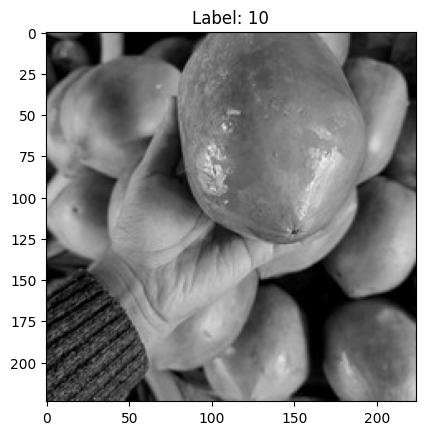

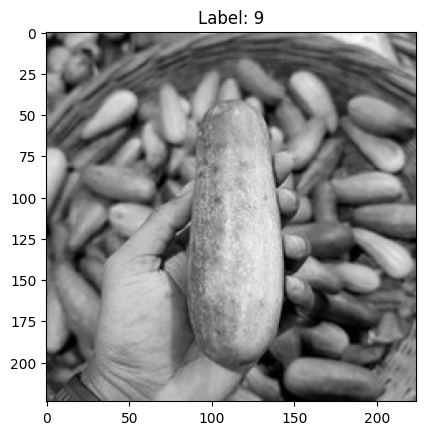

In [5]:
#sample to check if the data is loaded correctly

for batch in train.take(1):
    plt.figure()
    plt.imshow(batch[0][0]) 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in test.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in validation.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()

In [6]:

label_counts = {}

for batch in train:
    _, labels = batch 
    labels = batch[1][0].numpy()
    if str(labels) in label_counts:
        label_counts[str(labels)] += 1
    else:
        label_counts[str(labels)] = 1

for label, count in label_counts.items():
    print(f"Label {label}: Count {count}")


Label [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 27
Label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 14
Label [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 27
Label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 27
Label [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]: Count 5
Label [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]: Count 27
Label [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]: Count 31
Label [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 11
Label [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]: Count 26
Label [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 22
Label [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]: Count 13
Label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]: Count 23
Label [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]: Count 12
Label [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: Count 11
Label [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]: Count 7


## Interpreting the Previous Output

Based on the output of the previous cell, we can see that the dataset is not evenly distributed across all labels. This can be problematic for our model, as it may not be able to learn from the data effectively if it is biased towards certain labels.

## Shifting Weights in the Model

One way to address this issue is to shift the weights in the model to account for the uneven distribution of labels. This can be done by assigning higher weights to underrepresented labels and lower weights to overrepresented labels.

For example, we can use the `class_weight` parameter in Keras to assign weights to each class based on their frequency in the dataset. This will ensure that the model pays more attention to underrepresented classes during training.


# Feature engineering or data augmentation


In [7]:
train_31 = train.map(lambda x, y: (tf.image.resize(x, (31, 31)), y))
train_128 = train.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))

validation_31 = validation.map(lambda x, y: (tf.image.resize(x, (31, 31)), y))
validation_128 = validation.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))

In [8]:
train31_images = np.concatenate([image.numpy() for image, label in train_31], axis = 0)
train31_labels = np.concatenate([label.numpy() for image, label in train_31], axis = 0)

train128_images = np.concatenate([image.numpy() for image, label in train_128], axis = 0)
train128_labels = np.concatenate([label.numpy() for image, label in train_128], axis = 0)

validation31_images = np.concatenate([image.numpy() for image, label in validation_31], axis = 0)
validation31_labels = np.concatenate([label.numpy() for image, label in validation_31], axis = 0)

validation128_images = np.concatenate([image.numpy() for image, label in validation_128], axis = 0)
validation128_labels = np.concatenate([label.numpy() for image, label in validation_128], axis = 0)


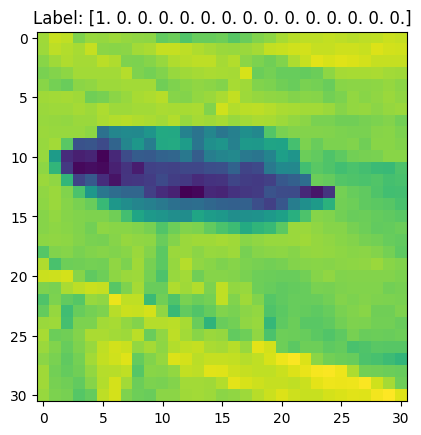

In [9]:
for batch in train_31.take(1):
    plt.figure()
    plt.imshow(batch[0][0]) 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()

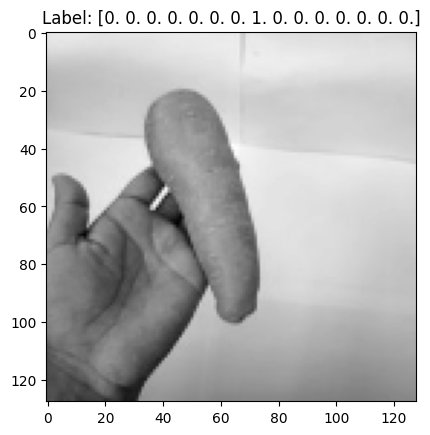

In [10]:
for batch in train_128.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()

# Modelling and evaluation

In [19]:
validation31_labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Epoch 1/10
283/283 - 6s - loss: 2.6483 - accuracy: 0.0989 - val_loss: 2.7889 - val_accuracy: 0.0667 - 6s/epoch - 23ms/step
Epoch 2/10
283/283 - 2s - loss: 2.6398 - accuracy: 0.1005 - val_loss: 2.7774 - val_accuracy: 0.0667 - 2s/epoch - 5ms/step
Epoch 3/10
283/283 - 2s - loss: 2.6387 - accuracy: 0.1041 - val_loss: 2.7781 - val_accuracy: 0.0667 - 2s/epoch - 5ms/step
Epoch 4/10
283/283 - 2s - loss: 2.6370 - accuracy: 0.1043 - val_loss: 2.7854 - val_accuracy: 0.0667 - 2s/epoch - 5ms/step
Epoch 5/10
283/283 - 2s - loss: 2.6374 - accuracy: 0.1053 - val_loss: 2.7996 - val_accuracy: 0.0667 - 2s/epoch - 5ms/step
Epoch 6/10
283/283 - 2s - loss: 2.6364 - accuracy: 0.1046 - val_loss: 2.8134 - val_accuracy: 0.0667 - 2s/epoch - 5ms/step
Epoch 7/10
283/283 - 2s - loss: 2.6371 - accuracy: 0.1047 - val_loss: 2.7819 - val_accuracy: 0.0637 - 2s/epoch - 5ms/step
Epoch 8/10
283/283 - 2s - loss: 2.6340 - accuracy: 0.1051 - val_loss: 2.7945 - val_accuracy: 0.0660 - 2s/epoch - 5ms/step
Epoch 9/10
283/283 - 2s

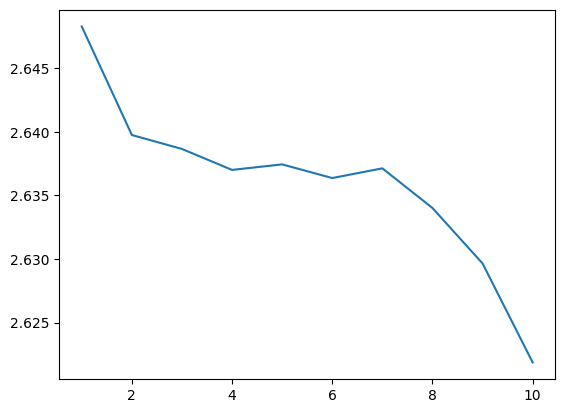

In [11]:
# normalize inputs from 0-255 to 0-1
train31_images = train31_images / 255
validation31_images = validation31_images / 255
# one hot encode outputs
validation31_labels = to_categorical(validation31_labels)

model_31 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31.fit(train31_images, train31_labels, validation_data=(validation31_images, validation31_labels),
 epochs=10, batch_size=32, verbose=2)
scores = model_31.evaluate(validation31_images, validation31_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1,11),  history.history['loss'])


In [28]:
# normalize inputs from 0-255 to 0-1
train128_images = train128_images / 255
validation128_images = validation128_images / 255
# one hot encode outputs
validation128_labels = to_categorical(validation128_labels)

model_128 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_128.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_128.fit(train128_images, train128_labels, validation_data=(validation128_images, validation128_labels),
 epochs=10, batch_size=32, verbose=2)
scores = model_128.evaluate(validation128_images, validation128_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1,11),  history.history['loss'])


Epoch 1/10


ValueError: in user code:

    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 15, 2) and (None, 15) are incompatible


## Base Model Evaluation

As we can see, the base model has extremely poor accuracy . This could be due to the fact that the model is not able to learn from the data effectively, as it is biased towards certain labels. We can address this issue by shifting the weights in the model to account for the uneven distribution of labels. We can also try to improve the model by adding more layers and increasing the number of epochs while implementing a proper early stopping mechanism as well as a proper structure for the model.

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

def AlexNet(input_shape, num_classes=15):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (3, 3), activation='relu', input_shape=(input_shape, input_shape, 1), padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(4096, activation='relu'))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [32]:
from keras.optimizers import Adam

def Lenet(input_shape, num_classes=15):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape, input_shape, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Convolutional Layer 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    # Fully Connected Layer 1
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    # Fully Connected Layer 2 (output layer)
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = Lenet(31)
history = model.fit(train31_images, train31_labels, validation_data=(validation31_images, validation31_labels),
                    epochs=10, batch_size=32, verbose=2)

scores = model.evaluate(validation31_images, validation31_labels, verbose=5)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1, 101), history.history['loss'])

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

Epoch 1/10
283/283 - 3s - loss: 2.6450 - accuracy: 0.1015 - val_loss: 2.7900 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 2/10
283/283 - 2s - loss: 2.6385 - accuracy: 0.1038 - val_loss: 2.7952 - val_accuracy: 0.0667 - 2s/epoch - 7ms/step
Epoch 3/10
283/283 - 2s - loss: 2.6390 - accuracy: 0.1041 - val_loss: 2.7855 - val_accuracy: 0.0667 - 2s/epoch - 7ms/step
Epoch 4/10
283/283 - 2s - loss: 2.6378 - accuracy: 0.1000 - val_loss: 2.7733 - val_accuracy: 0.0667 - 2s/epoch - 7ms/step
Epoch 5/10


In [27]:
train31_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
# 31x31 alexnet 

model = AlexNet(31)
history = model.fit(train31_images, train31_labels, validation_data=(validation31_images, validation31_labels),
                    epochs=100, batch_size=200, verbose=2)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1, 101), history.history['loss'])

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

Epoch 1/100
46/46 - 3s - loss: 2.6623 - accuracy: 0.0936 - val_loss: 2.7797 - val_accuracy: 0.0667 - 3s/epoch - 60ms/step
Epoch 2/100
46/46 - 1s - loss: 2.6385 - accuracy: 0.1021 - val_loss: 2.7817 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 3/100
46/46 - 1s - loss: 2.6403 - accuracy: 0.0998 - val_loss: 2.7750 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 4/100
46/46 - 1s - loss: 2.6377 - accuracy: 0.1015 - val_loss: 2.7985 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 5/100
46/46 - 1s - loss: 2.6379 - accuracy: 0.1058 - val_loss: 2.7803 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 6/100
46/46 - 1s - loss: 2.6377 - accuracy: 0.1014 - val_loss: 2.7703 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 7/100
46/46 - 1s - loss: 2.6375 - accuracy: 0.1058 - val_loss: 2.7683 - val_accuracy: 0.0667 - 1s/epoch - 24ms/step
Epoch 8/100
46/46 - 1s - loss: 2.6375 - accuracy: 0.1058 - val_loss: 2.7862 - val_accuracy: 0.0667 - 1s/epoch - 24ms/step
Epoch 9/100
46/46 - 1s -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Baseline Error: 93.37%


KeyboardInterrupt: 

Epoch 1/100
46/46 - 2s - loss: 0.0253 - accuracy: 0.0724 - val_loss: 132.9715 - val_accuracy: 0.0667 - 2s/epoch - 47ms/step
Epoch 2/100
46/46 - 1s - loss: 0.7781 - accuracy: 0.0702 - val_loss: 3141.7283 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 3/100
46/46 - 1s - loss: 4.9732 - accuracy: 0.0672 - val_loss: 14744.1279 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 4/100
46/46 - 1s - loss: 19.2052 - accuracy: 0.0695 - val_loss: 56979.5195 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 5/100
46/46 - 1s - loss: 64.2821 - accuracy: 0.0698 - val_loss: 141110.6562 - val_accuracy: 0.0667 - 1s/epoch - 31ms/step
Epoch 6/100
46/46 - 1s - loss: 134.0662 - accuracy: 0.0707 - val_loss: 398606.5938 - val_accuracy: 0.0667 - 1s/epoch - 31ms/step
Epoch 7/100
46/46 - 1s - loss: 279.4464 - accuracy: 0.0686 - val_loss: 426831.9062 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 8/100
46/46 - 1s - loss: 426.5869 - accuracy: 0.0621 - val_loss: 810865.7500 - val_accuracy: 0.0667 - 1s/e

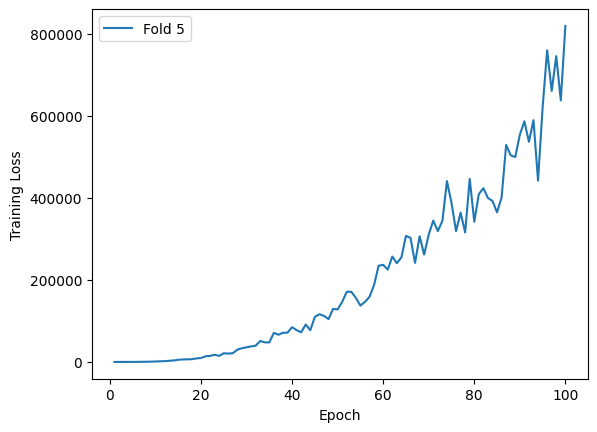

In [ ]:
model = Lenet(128)
history = model.fit(train128_images, train128_labels, validation_data=(validation128_images, validation128_labels),
                    epochs=100, batch_size=200, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1, 101), history.history['loss'])

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()

In [ ]:
# # Define the number of folds for cross-validation
# num_folds = 5
# input_shape = 31  # Adjust as needed

# # Create K-Fold cross-validation splits
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# loss_history = []

# for train_index, test_index in kf.split(train31_images):
#     train_x, test_x = train31_images[train_index], train31_images[test_index]
#     train_y, test_y = train31_labels[train_index], train31_labels[test_index]

#     model = Lenet(input_shape)

#     # Train the model
#     history = model.fit(train_x, train_y, validation_data=(test_x, test_y),
#                         epochs=100, batch_size=200, verbose=2)
    
#     loss_history.append(history)

# # Calculate and print the mean baseline error
# mean_baseline_error = 100 - np.mean([history.history['val_accuracy'][-1] * 100 for history in loss_history])
# print("Mean Baseline Error: %.2f%%" % mean_baseline_error)

# # Plot the training loss for each fold
# for i, history in enumerate(loss_history):
#     plt.plot(np.arange(1, 101), history.history['loss'], label=f"Fold {i + 1}")

# plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
# plt.legend()
# plt.show()